In [4]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import numpy as np
from collections import defaultdict


### Extract

In [5]:
events = pd.read_csv("events.csv")

print(events.head(3))

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN


### Transform

In [6]:
# 1. Map event types to numeric ratings
rating_map = {"view":1, "addtocart":2, "transaction":3}
events["rating"] = events["event"].map(rating_map)

# 2. Keep only the columns needed for SVD
events = events[["visitorid", "itemid", "rating"]]

# 3. Drop missing rows
events.dropna(inplace=True)


# 4. Keep the highest rating
events = events.groupby(["visitorid", "itemid"], as_index=False)["rating"].max()

print(events.head())
print("Unique users:", events["visitorid"].nunique())
print("Unique items:", events["itemid"].nunique())

   visitorid  itemid  rating
0          0   67045       1
1          0  285930       1
2          0  357564       1
3          1   72028       1
4          2  216305       1
Unique users: 1407580
Unique items: 235061


### Load

In [7]:
# Reader object for Surprise Dataset
reader = Reader(rating_scale=(1, 3))

# Load the DataFrame into a Surprise Dataset
data = Dataset.load_from_df(events[["visitorid", "itemid", "rating"]], reader)

## Using Collaborative Filtering Approach And SVD algorithm

### SVD Model Training

In [8]:
# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# initialize SVD (matrix factorization)
svd = SVD()
svd.fit(trainset)

predictions = svd.test(testset)

accuracy.rmse(predictions)

RMSE: 0.2343


0.23432148246387738

### Make Top-N Recommendations for a User

In [9]:
# Function to get top-N recommendations for a given user
def get_top_n(predictions, n=5):
    from collections import defaultdict
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort and take top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [10]:
# All raw user IDs present in the training set
train_users = [trainset.to_raw_uid(uid) for uid in trainset.all_users()]
print("Number of training users:", len(train_users))
print("Sample IDs:", train_users[:10])  # peek at a few


Number of training users: 1176211
Sample IDs: [1184927, 1106058, 1296469, 839628, 1085997, 457962, 7371, 136827, 1306216, 979843]


In [11]:
# or any other from the list
target_user = train_users[0]


In [12]:
# One target user and predict onnly unseen items"
user_inner_id = trainset.to_inner_uid(target_user)

seen_items = {iid for (iid, _) in trainset.ur[user_inner_id]}

preds = []

for inner_iid in trainset.all_items():
    if inner_iid not in seen_items:
        raw_iid = trainset.to_raw_iid(inner_iid)
        preds.append(svd.predict(target_user, raw_iid))

# get Top-5 recommendations
top_n = get_top_n(preds, n=5)

print(f'Top-5 recommendations for user {target_user}:')
print(top_n[target_user])

Top-5 recommendations for user 1184927:
[(450760, 1.5966861639653651), (457970, 1.5674733862526071), (304880, 1.5285389351351641), (439352, 1.513025908588557), (167827, 1.5116375738309842)]


In [13]:
# Utility Functions
def load_data(event_map):
    df = pd.read_csv("events.csv")
    df = df[df['event'].isin(event_map.keys())]
    df['rating'] = df['event'].map(event_map)
    df = df.groupby(['visitorid', 'itemid'], as_index=False)['rating'].max()
    reader = Reader(rating_scale=(min(event_map.values()), max(event_map.values())))
    return Dataset.load_from_df(df[['visitorid', 'itemid', 'rating']], reader)

def precision_recall_at_k(predictions, k=10, threshold=1.0):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel else 0
    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))


### Experiment 1: Baseline vs SVD

In [14]:
# Map events to ratings
event_map = {"view":1, "addtocart":2, "transaction":3}
data = load_data(event_map)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# SVD Model
algo = SVD(n_factors=100, n_epochs=20)
algo.fit(trainset)
preds = algo.test(testset)
rmse = accuracy.rmse(preds)
prec, rec = precision_recall_at_k(preds, k=10, threshold=2)

print(f"SVD -> RMSE:{rmse:.3f}, Precision@10:{prec:.3f}, Recall@10:{rec:.3f}")

# Popularity baseline: recommend most frequently purchased items
df = pd.read_csv("events.csv")
pop_items = df[df["event"] == "transaction"]["itemid"].value_counts().index[:10]
print("Top popular items baseline:", list(pop_items))

RMSE: 0.2343
SVD -> RMSE:0.234, Precision@10:0.000, Recall@10:0.000
Top popular items baseline: [461686, 119736, 213834, 312728, 7943, 445351, 48030, 420960, 248455, 17478]


In [19]:
import matplotlib.pyplot as plt 

# Putting results into python lists
exp1_models = ['SVD', 'Popularity']
exp1_rmse = [0.234, 0.2343]
exp1_prec = [0.000, 0.000]
exp1_rec = [0.000, 0.000]

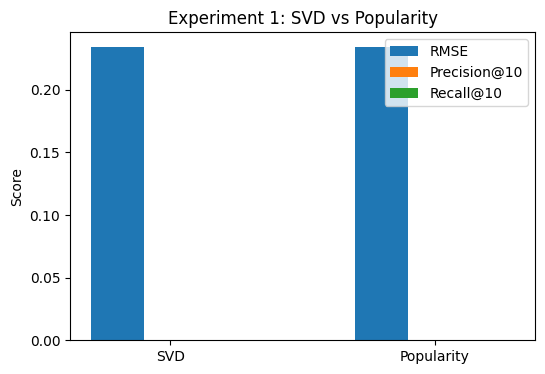

In [20]:
x = np.arange(len(exp1_models))
plt.figure(figsize=(6,4))
plt.bar(x-0.2, exp1_rmse, width=0.2, label='RMSE')
plt.bar(x, exp1_prec, width=0.2, label='Precision@10')
plt.bar(x+0.2, exp1_rec, width=0.2, label='Recall@10')
plt.xticks(x, exp1_models)
plt.ylabel("Score")
plt.title("Experiment 1: SVD vs Popularity")
plt.legend()
plt.show()

### Experiment 2: Event-to-Rating Mapping Variants

In [15]:
mappings = {
    "binary": {"view":1, "addtocart":1, "transcation":1},
    "ordinal": {"view":1, "addtocart":2, "transcation":3},
    "purchase_weighted": {"view":1, "addtocart":2, "transaction":5}
}

for name, emap in mappings.items():
    data = load_data(emap)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    algo = SVD(n_factors=100, n_epochs=20)
    algo.fit(trainset)
    preds = algo.test(testset)
    rmse = accuracy.rmse(preds, verbose=False)
    prec, rec = precision_recall_at_k(preds, k=10, threshold=1.0)
    print(f"{name}: RMSE {rmse:.3f}, Precision@10 {prec:.3f}, Recall@10{rec:.3f}")

binary: RMSE 0.000, Precision@10 1.000, Recall@100.999
ordinal: RMSE 0.164, Precision@10 1.000, Recall@100.999
purchase_weighted: RMSE 0.408, Precision@10 1.000, Recall@100.999


In [21]:
exp2_variants = ['Binary', 'Ordinal', 'Purchase-weighted']
exp2_rmse = [0.000, 0.164, 0.408]
exp2_prec = [1.000, 1.000, 1.000]
exp2_rec = [0.999, 0.999, 0.999]

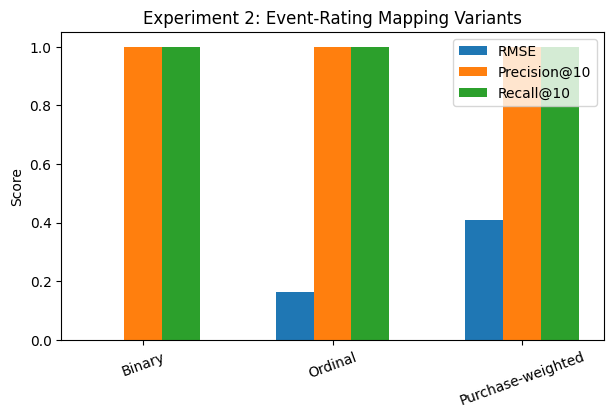

In [22]:
x = np.arange(len(exp2_variants))
plt.figure(figsize=(7,4))
plt.bar(x-0.2, exp2_rmse, width=0.2, label='RMSE')
plt.bar(x, exp2_prec, width=0.2, label='Precision@10')
plt.bar(x+0.2, exp2_rec, width=0.2, label='Recall@10')
plt.xticks(x, exp2_variants, rotation=20)
plt.ylabel("Score")
plt.title("Experiment 2: Event-Rating Mapping Variants")
plt.legend()
plt.show()

### Experiment 3: Hyperparameter Tuning

In [16]:
param_grid = [(20,0.02,10), (50,0.02,20), (100,0.02,20), (100,0.002,20)]
best = None
for n_factors, reg, epochs in param_grid:
    algo = SVD(n_factors=n_factors, reg_all=reg, n_epochs=epochs)
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    mean_rmse = np.mean(results['test_rmse'])
    print(f"factors={n_factors}, reg={reg}, epochs{epochs}, RMSE={mean_rmse:.3f}")
    if not best or mean_rmse < best[0]:
        best = (mean_rmse, n_factors, reg, epochs)

print(f"Best params: factors={best[1]}, reg={best[2]}, epochs={best[3]} with RMSE {best[0]:.3f}")

factors=20, reg=0.02, epochs10, RMSE=0.402
factors=50, reg=0.02, epochs20, RMSE=0.404
factors=100, reg=0.02, epochs20, RMSE=0.405
factors=100, reg=0.002, epochs20, RMSE=0.408
Best params: factors=20, reg=0.02, epochs=10 with RMSE 0.402


In [23]:
exp3_labels = ['20 factors', '50 factors', '100 factors\nreg=0.02', '100 factors\nreg=0.002']
exp3_rmse = [0.402, 0.404, 0.405, 0.408]

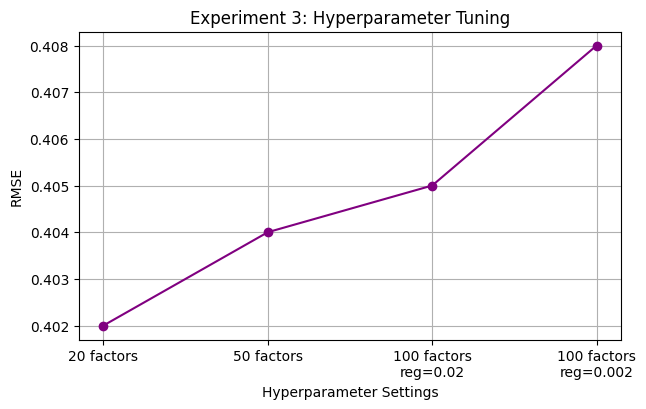

In [24]:
plt.figure(figsize=(7,4))
plt.plot(exp3_labels, exp3_rmse, marker='o', linestyle='-', color='purple')
plt.xlabel("Hyperparameter Settings")
plt.ylabel("RMSE")
plt.title("Experiment 3: Hyperparameter Tuning")
plt.grid(True)
plt.show()
